# Load Packages

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")

import torch
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import random
import pandas as pd

from models.CAE import CAE
from train import Trainer
from interpretability import *
from dataloader import ElectricDevices, normalize
from utils import baseline

from scipy.ndimage import gaussian_filter1d

from pingouin import distance_corr # Szekely and Rizzo

import hydra
from hydra.experimental import initialize, initialize_config_dir, compose

from utils import get_shapley_values, get_layer_attrs, get_neuron_attrs

torch.manual_seed(4444)
np.random.seed(4444)
random.seed(4444)

# Data Preprocessing

In [2]:
with initialize_config_dir(config_dir=os.path.abspath("../src/configs")):
    cfg = compose(config_name="config")
print(cfg)

diverging_colors = sns.color_palette("RdBu", 9)

data_train_ori, data_valid_ori, data_test_ori = ElectricDevices()
data_train, data_valid, data_test = normalize(data_train_ori), normalize(data_valid_ori), normalize(data_test_ori)
X_train, y_train = data_train[:,:,:-1], data_train[:,:,-1]
X_valid, y_valid = data_valid[:,:,:-1], data_valid[:,:,-1]
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1]

{'model': {'M': 4, 'Lf': 3, 'length': 96, 'bottleneck_nn': 24, 'lmd': 1.0979131326372968e-05, 'alpha': 0.05}, 'train': {'verbose': True, 'shuffle': True, 'batch_size': 64, 'iters': 300, 'early_stopping_rounds': 23, 'lr': 0.001706322160346846}}


# Data Exploration

## Compare to baseline

In [ ]:
# baseline(data_train, data_valid, data_test)

# Model

In [3]:
model = CAE(cfg.model, num_classes=7)

# torch.save(model.state_dict(), "../pretrained_models/mod.pth")
model.load_state_dict(torch.load("../pretrained_models/mod.pth"))

<All keys matched successfully>

In [ ]:
# trainer = Trainer(cfg.train)
# train_losses, valid_losses = trainer.fit(model, data_train, data_valid)

In [ ]:
# plt.title("Cost")
# plt.plot(train_losses, label="train")
# plt.plot(valid_losses, label="validation")
# plt.legend()

In [4]:
selected = [3279, 1156, 7419, 5046, 3323, 6485,5497]

## Evaluation

Reconstruction

In [ ]:
X_test, y_test = data_test[:,:,:-1], data_test[:,:,-1].numpy()
X_testp, outclass_testp, bn = model(X_test, apply_noise=False)
X_testp = X_testp.detach().numpy()
probs_testp = model.classifier.get_probs(outclass_testp)
y_testp = torch.argmax(probs_testp, dim=1).detach().numpy()

# avg and std of cors
cors = [distance_corr(X_testp[i,0], X_test[i,0].detach().numpy(), n_boot=None) for i in range(X_test.shape[0])]
print("Distance Correlation avg and std:", np.mean(cors), np.std(cors))
print("NRMSE:", (torch.sqrt(torch.mean(torch.square(X_test-X_testp)))/(torch.max(X_test)-torch.min(X_test))).item())
print()

Classification

In [ ]:
cm = confusion_matrix(y_test, y_testp)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")

print("Accuracy:", np.sum(np.diag(cm))/np.sum(cm))

Exploration of predictions

In [ ]:
# selected = np.random.choice(range(1000), 7)

fig, axs = plt.subplots(nrows=2, ncols=len(selected), figsize=(25,5), constrained_layout=True)
for i, x in enumerate(selected): #selected):
    vals = data_test_ori[x,0,:-1]
    min_v, max_v = torch.min(vals), torch.max(vals)
    axs[0,i].set_title(f"C: {int(y_test[x][0])} (min={min_v:.2f}, max={max_v:.2f})")
    axs[0,i].plot(X_test[x,0])
    axs[0,i].axis("off")
    axs[0,i].set_ylim((0,1))

    axs[1,i].set_title(f"Pred: {int(y_testp[x])}")
    axs[1,i].plot(X_testp[x,0])
    axs[1,i].axis("off")
    axs[1,i].set_ylim((0,1))

    print("cor:", distance_corr(X_testp[x,0], X_test[x,0], n_boot=None))

# Interpretability

## Importance of filters

In [ ]:
num_filter = model.k*model.M
w_per_filter = model.length
num_neurons = model.bottleneck_nn
M = model.M

w = np.array([[torch.mean(torch.abs(model.encoder.fc_conv_bn.weight[j,i*w_per_filter:(i+1)*w_per_filter])).item() for i in range(num_filter)] for j in range(num_neurons)])
x_axis_labels = [f"{i}-d:{model.dilation[i//M]}" for i in range(w.shape[1])]

_ = sns.heatmap(w, xticklabels=x_axis_labels, cmap="gray", vmin=0)

## Distribution of data

In [ ]:
ax = sns.histplot(X_train.flatten())
ax.set(xlabel="Training input values")
ax.get_figure().savefig("sv_data-distribution.png")

## Distribution of neurons

Extract bottlenecks from the training data

In [ ]:
_, _, bn = model(X_train, False)
bn = bn.detach().numpy()
y_train_np = np.array(y_train, dtype=np.int8).flatten()

baselines = np.mean(bn, axis=0) # mean value of each neuron on the whole training dataset

Distribution in one histogram

In [ ]:
aux = pd.DataFrame({"Bottleneck": bn.flatten(), "Class": np.tile(range(24), bn.shape[0])})
sns.histplot(data=aux, x="Bottleneck", hue="Class", palette=sns.color_palette("tab10",24), kde=True)

Distribution in each neuron

In [ ]:
fig1, axs = plt.subplots(nrows=5, ncols=5, figsize=(25,20), constrained_layout=True)
axs[4,4].set_axis_off()
for i in range(24):
    aux = pd.DataFrame({"x": bn[:,i]})
    axs.flat[i].set_title(f"Neuron {i}")
    sns.histplot(data=aux, x="x", ax=axs.flat[i], kde=True)

Distribution in each neuron for each class

In [ ]:
fig2, axs = plt.subplots(nrows=5, ncols=5, figsize=(25,20), constrained_layout=True)
axs[4,4].set_axis_off()
for i in range(24):
    aux = pd.DataFrame({"Bottleneck": bn[:,i], "Class": y_train_np})
    axs.flat[i].set_title(f"Neuron {i}")
    sns.kdeplot(data=aux, x="Bottleneck", hue="Class", palette=sns.color_palette("tab10",7), ax=axs.flat[i])

In [ ]:
# fig1.savefig("distribution_of_neurons.png")
# fig2.savefig("distribution_of_neurons_class.png")

## Feature Visualization

Input that maximizes neuron

In [ ]:
# for i in range(24):
#     a1 = feature_visualization(model, i, 2)
#     plt.plot(a1, "o-")
#     plt.title(f"Neuron {i}")
#     plt.ylim(-0.05, 1.05)
#     plt.savefig(f"../plots/{i}.png")
#     plt.close()

Input that maximizes class

In [ ]:
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,10), constrained_layout=True)
# for i in range(7): #selected):
#     a1 = feature_visualization(model, i, 1)
#     axs.flat[i].plot(a1)
#     axs.flat[i].set_title(f"Representant class {i}")
#     axs.flat[i].set_ylim(-0.05, 1.05)

## Shapley Value Sampling

In [26]:
hist_input = [get_hist(X_train[:,0,i]) for i in range(96)]

In [27]:
aux = model.encoder(X_train, False).detach().numpy()
hist_bn = [get_hist(aux[:,i]) for i in range(24)]

Importance of input with respect to outputs

In [ ]:
func = lambda x: model(x.reshape(-1,1,96), False)[0][:,0]
f_attrs = lambda inp: np.array([shapley_sampling(inp, func, j, hist_input) for j in range(model.length)])

fig1, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15), constrained_layout=True)
axs = np.array(axs)
axs[2,1].set_axis_off()
axs[2,2].set_axis_off()
for i, x in enumerate(selected):
    attrs = f_attrs(X_test[x,0])

    ax = sns.heatmap(attrs, ax=axs.flatten()[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})
    ax.set(xlabel="Output Time Series", ylabel="Input Time Series")

    ax = axs.flatten()[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], label="Original", color="green", ax=ax)
    sns.lineplot(x=range(96), y=model(X_test[x,0].reshape(1,1,-1), False)[0][0,0].detach().numpy(), label="Predicted", color="purple", ax=ax)
    ax.legend()

Importance of bottleneck with respect the outputs

In [ ]:
func = lambda x: model.decoder(x)[:,0,:]
f_attrs = lambda inp: np.array([shapley_sampling(inp, func, j, hist_bn) for j in range(model.bottleneck_nn)])

fig2, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15), constrained_layout=True)
axs = np.array(axs)
axs[2,1].set_axis_off()
axs[2,2].set_axis_off()
for i, x in enumerate(selected):
    inp = model.encoder(X_test[x,0].reshape(1,1,-1), False).flatten()
    attrs = f_attrs(inp)

    ax = sns.heatmap(attrs, ax=axs.flatten()[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})
    ax.set(xlabel="Output Time Series", ylabel="Input Bottleneck")

    ax = axs.flatten()[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], label="Original", color="green", ax=ax)
    sns.lineplot(x=range(96), y=model(X_test[x,0].reshape(1,1,-1), False)[0][0,0].detach().numpy(), label="Predicted", color="purple", ax=ax)
    ax.legend()

Importance of input with respect the bottleneck

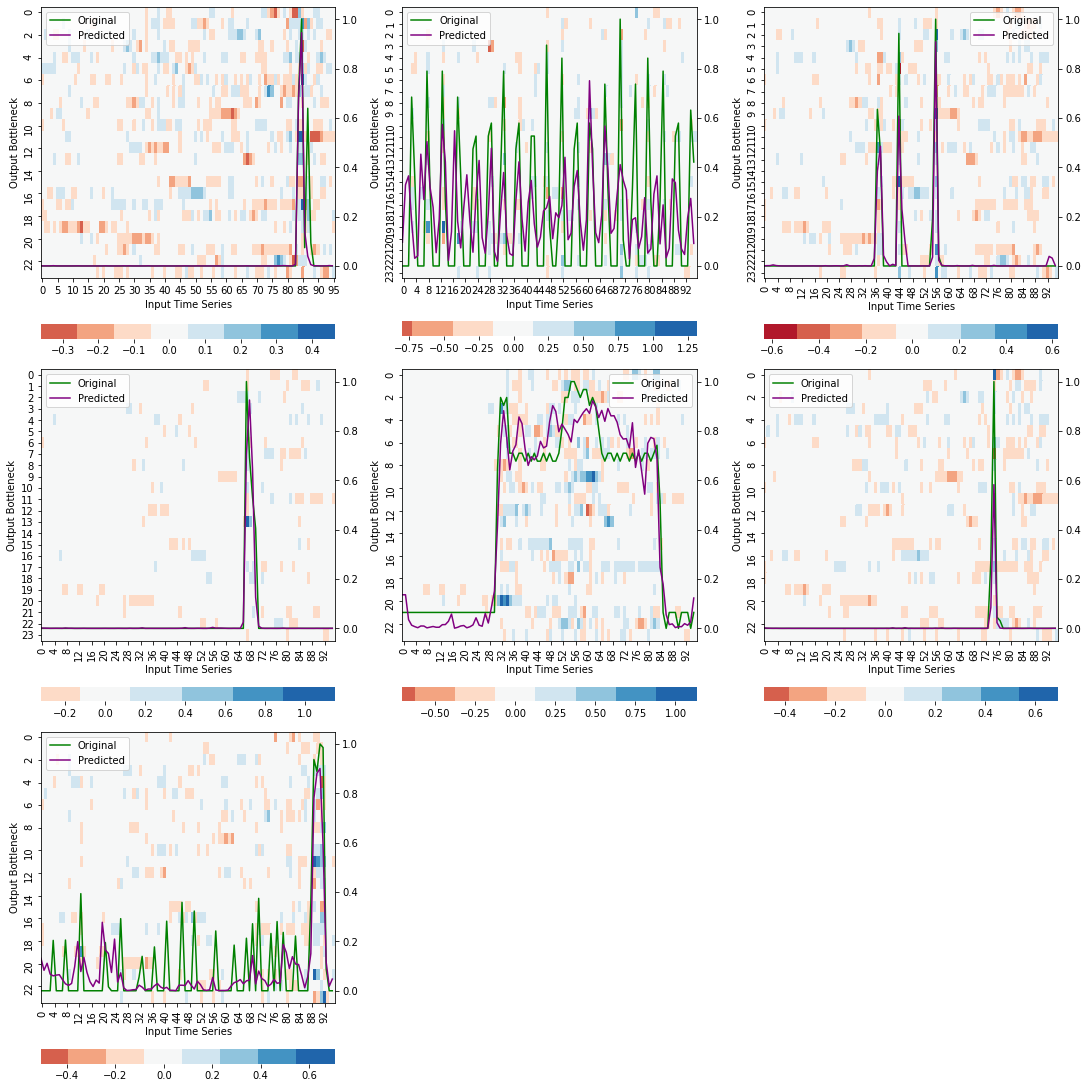

In [28]:
func = lambda x: model.encoder(x.reshape(-1,1,96), False)
f_attrs = lambda inp: np.array([shapley_sampling(inp, func, j, hist_input) for j in range(model.length)]).T

fig3, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15), constrained_layout=True)
axs = np.array(axs)
axs[2,1].set_axis_off()
axs[2,2].set_axis_off()
for i, x in enumerate(selected):
    inp = X_test[x,0]
    attrs = f_attrs(inp)

    ax = sns.heatmap(attrs, ax=axs.flatten()[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})
    ax.set(xlabel="Input Time Series", ylabel="Output Bottleneck")

    ax = axs.flatten()[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], label="Original", color="green", ax=ax)
    sns.lineplot(x=range(96), y=model(X_test[x,0].reshape(1,1,-1), False)[0][0,0].detach().numpy(), label="Predicted", color="purple", ax=ax)

Importance of bottleneck with respect the class

In [ ]:
func = lambda x: model.classifier.get_probs(model.classifier(x.reshape(-1, 24)))
f_attrs = lambda inp: np.array([shapley_sampling(inp, func, j, hist_bn) for j in range(model.bottleneck_nn)])

fig4, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8), constrained_layout=True)
axs = np.array(axs)
# axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    inp = model.encoder(X_test[x,0].reshape(1,1,-1), False).flatten()
    attrs = f_attrs(inp)

    ax = sns.heatmap(attrs, ax=axs.flatten()[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})
    ax.set(xlabel="Output Class", ylabel="Input Bottleneck")

Importance of input with respect class

In [ ]:
func = lambda x: model.classifier.get_probs(model.classifier(model.encoder(x.reshape(-1,1,96), False)))
f_attrs = lambda inp: np.array([shapley_sampling(inp, func, j, hist_input) for j in range(model.length)]).T

fig5, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8), constrained_layout=True)
axs = np.array(axs)
# axs[1,3].set_axis_off()
for i, x in enumerate(selected):
    inp = X_test[x,0]
    attrs = f_attrs(inp)

    ax = sns.heatmap(attrs, ax=axs.flatten()[i], center=0, cmap=diverging_colors, cbar_kws={"orientation": "horizontal"})
    ax.set(xlabel="Input Time Series", ylabel="Output Bottleneck")

    ax = axs.flatten()[i].twinx()
    sns.lineplot(x=range(96), y=X_test[x,0], label="Original", color="green", ax=ax)
    sns.lineplot(x=range(96), y=model(X_test[x,0].reshape(1,1,-1), False)[0][0,0].detach().numpy(), label="Predicted", color="purple", ax=ax)

In [29]:
# fig1.savefig("sv_input-output_dist.png", dpi=100)
# fig2.savefig("sv_bottleneck-output_1minus.png")
# fig3.savefig("sv_input-bottleneck_dist.png")
# fig4.savefig("sv_bottleneck-class.png")
# fig5.savefig("sv_input-class.png")